# The origine of Music dataset

## Index
1. [Introduction](#part1)
2. [Load the data](#part2)
3. [Data description](#part3)  
    1. [Data preparation](#part31)  
    2. [Data visualization](#part32)  
        1. [Country distribution](#part321)  
        2. [Feature visualization](#part322)  
4. [Simple multi class logistic regression using the lm function](#part4)  
    1. [Data preparation](#part41)  
    2. [Run a single logistic regression for a given training set size ](#part42)  
        1. [Learn the parameters Theta \[31 x 68\] using the training set](#part421)  
        2. [Use the learned parameter to predict on the test set ](#part422)  
        3. [Mesure the accuracy of the algorithme](#part423)  
    3. [Study accuracy VS training set size](#part43)  

## 1. Introduction <a name="part1"></a>

We will be studying the dataset called *Geographical Original of Music* which can be found on the [UCI Machine learning site](https://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music)  
This dataset contains audio feature from 1059 songs labelled with their country of origine.  
The purpose of this dataset is to predict the country of origine of songs automaticaly.  
Their are 33 countries represented in this dataset.
The music used is traditional, ethnic or "world" only, as classified by the publishers of the product on which it appears. Any Western music is not included because its influence is global - what we seek are the aspects of music that most influence location

In [2]:
library("repr")
library("ggplot2")
library("stats")
library("scales")
library("stringr")
library("zoo")
library("dplyr")


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## 2. Load the data <a name="part2"></a>

In [3]:
path<-file.path("..","data","default_features_1059_tracks.txt")
df<-read.csv(path, header = FALSE, stringsAsFactors = F)

## 3. Data description <a name="part3"></a>

The dataset is a **1059 x 70** table of **numerics**. When loaded into R using ```pryr::object_size``` we can check the dataframe only takes 601kB.  
The first **68** columns are the **features** and the last 2 columns are the longitude and latitude where the music was produce.  
We will convert the output columns into a single column with the corresponding **country** which will be are **target**.


### A. Data preparation <a name="part31"></a>

#### 3.1.1. Seperate features from outputs 

In [4]:
X<-df[,1:68]
Y<-df[,c(69,70)]

#### 3.1.2. Transform outputs lattitude and longitude into Country Code

##### 3.1.2.1. Define a function with lattitude and longitude as inputs and Country Code as output

In [5]:
getCountry<-function(lat,lon){
  library(httr)
  address<-paste0("http://api.geonames.org/countryCode?lat=",lat,"&lng=",lon,"&username=nicolasn")
  resp<-httr::GET(url = address, config = list(type = "JSON"))
  country<-content(resp, "text", encoding = "UTF-8")
  country<-sub("\n","",country)
  country<-sub("\r","",country)
  return(country)
}

##### 3.1.2.2. Apply this function to the output 

In [6]:
Ycountry<-mapply(getCountry,Y[,1],Y[,2])

##### 3.1.2.3. Clean up error country

In [7]:
X_clean<-X[Ycountry != "ERR:15:no country code found",]
Y_clean<-Ycountry[Ycountry != "ERR:15:no country code found"]

### B. Data visualization <a name="part32"></a>
#### a. Country distribution <a name="part321"></a>

In [8]:
options(repr.plot.width=6, repr.plot.height=3)

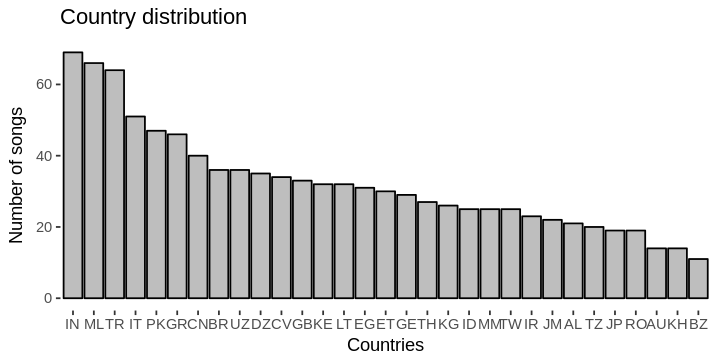

In [9]:
p<-ggplot(data.frame(Y_clean, stringsAsFactors = FALSE), aes( x = reorder(Y_clean, Y_clean, function(x)-length(x))))+
    geom_bar(color = "black" , fill = "grey") +
    labs(title = "Country distribution") +
    labs(x = "Countries") + 
    labs(y = "Number of songs") + 
    theme(panel.background = element_rect(fill = "white", colour = "white"))
p

### b. Feature visualization <a name="part322"></a>

#### i. PCA
We try to visualise the feature distribution by reducing the number of feature with a PCA.

In [10]:
ir.pca <- prcomp(X_clean, center = TRUE, scale. = TRUE) 

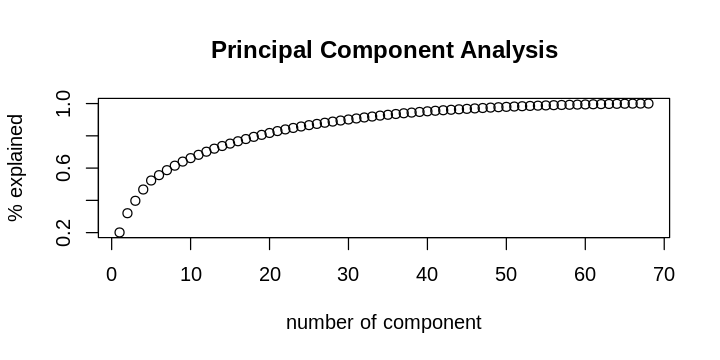

In [11]:
plot((summary(ir.pca)$importance[3,]), ylab = "% explained", xlab = "number of component")
title(main="Principal Component Analysis")

The plot shows that with 2 component we only retain 30% of the variation which is pretty low and thus ploting using only two components doesn't make a lot of sense.
The MARSYAS software output 68 features for some probably good reasons ! 

## 4. Simple multi class logistic regression using the lm function <a name="part4"></a>
### A. Data preparation <a name="part41"></a>
First we will separate our dataset into a training, a testing and a validation dataset

Then we will transform our dataframe into matrixes which suites better to logistic regressions
* The feature matrix : this is the X_clean data frame coerced into a matrix
* The target matrix : we need to use onehot encoding to transform the factor vector Y_clean into binary matrix with one column per factor

#### a. Shuffle dataset and split into training and test

In [12]:
set.seed(10)
random_order <- sample(1:length(Y_clean))
X_random <- X_clean[random_order,]
training_set_size<-800
X_train <- as.matrix(X_random[1:training_set_size,])
X_test <- as.matrix(X_random[(training_set_size+1):nrow(X_random),])

#### b.  Target : One hot encoding

In [19]:
library("onehot")

In [20]:
Y_random <- Y_clean[random_order]
encoder<-onehot::onehot(as.data.frame(Y_random),max_levels = 100)
Y_matrix<-predict(encoder,as.data.frame(Y_random))
colnames(Y_matrix)<-str_sub(colnames(Y_matrix),-2,-1) 

mapping<-cbind(colnames(Y_matrix), 1:ncol(Y_matrix))

Y_train_onehot <- Y_matrix[1:training_set_size,]
Y_test_onehot <- Y_matrix[(training_set_size+1):nrow(X_random),]
Y_train <- Y_random[1:training_set_size]
Y_test <- Y_random[(training_set_size+1):nrow(X_random)]

### B. Run a single logistic regression for a given training set size <a name="part42"></a>
#### a. Learn the parameters Theta \[31 x 68\] using the training set <a name="part421"></a>

In [21]:
# The objectives of the getTheta function are :
# 1. To be able to use the column number of the Y matrix as a an argument of the function lm
# 2. To easily extract the regression coeffecients from the lm function
get_theta <- function(i,Y,X){
    regression_output <- lm(Y[,i] ~ X)
    theta <- as.matrix(regression_output$coefficients)
    return(theta)
}

getTheta <- function(Y_onehot,X){
    Theta<-lapply(1:ncol(Y_onehot), get_theta, Y_onehot, X)
    return(Theta)
}


In [22]:
Theta <- getTheta(Y_train_onehot, X_train)

#### b. Use the learned parameter to predict on the test set <a name="part422"></a>

In [23]:
# The get_prediction return the prediction associated to X using theta
get_prediction <- function(ptheta,pX){
    theta_matrix<-as.matrix(ptheta)
    X_with_intercept <- cbind(as.matrix(rep(1,nrow(pX))),pX)
    prediction <- 1 / (1 + exp(- X_with_intercept %*% theta_matrix))
    return(prediction)
}

# The getPrediction return the prediction associated to X using Theta
getPrediction <- function(pTheta1,pX1){
    Y_predicted<-as.matrix(as.data.frame(lapply(pTheta1, get_prediction, pX1)))
    return(Y_predicted)
}

getPredictionAsCountryNames <- function(pTheta2, pX2){
    Y_predictions_matrix <- getPrediction(pTheta2,pX2)
    Y_prediction_binary_matrix <- Y_predictions_matrix == apply(Y_predictions_matrix,1, max)
    prediction_index<-max.col(Y_prediction_binary_matrix)
    predict_country<-mapping[prediction_index,1]
    return(predict_country)
}

In [24]:
prediction_output<-getPredictionAsCountryNames(Theta, X_test)

#### c. Mesure the accuracy of the algorithme <a name="part423"></a>

In [25]:
accuracy <- function(target,prediction){
    target_matrix<-as.matrix(target)
    prediction_matrix<-as.matrix(prediction)
    if(nrow(target_matrix) != nrow(prediction_matrix)){
        stop("Error : the target and the prediction don't have the same size")
    }
    return(sum(prediction_matrix == target_matrix)/nrow(target_matrix))
}

In [26]:
res<-accuracy(prediction_output, Y_test)

In [27]:
cat(paste0("The accuracy of the model is ", as.character(percent(res))))

The accuracy of the model is 39.1%

### C. Study accuracy VS training set size <a name="part43"></a>

In [28]:
accuracy_vs_trainingset_size<-function(n){
    X_train <- as.matrix(X_random[1:n,])
    X_test <- as.matrix(X_random[(n+1):nrow(X_random),])
    Y_train_onehot <- Y_matrix[1:n,]
    Y_test_onehot <- Y_matrix[(n+1):nrow(X_random),]
    Y_train <- Y_random[1:n]
    Y_test <- Y_random[(n+1):nrow(X_random)]
    
    Theta <- getTheta(Y_train_onehot, X_train)
    
    prediction_on_test <- getPredictionAsCountryNames(Theta, X_test)
    prediction_on_train <- getPredictionAsCountryNames(Theta, X_train)
    
    accuracy_on_test <- accuracy(prediction_on_test, Y_test)
    accuracy_on_train <- accuracy(prediction_on_train, Y_train)
    
    return(list(accuracy_on_test, accuracy_on_train))
}

In [29]:
accuracy_vs_trainingset_size_results<-unlist(lapply(100:900,accuracy_vs_trainingset_size))

In [30]:
accuracy_on_test <- accuracy_vs_trainingset_size_results[seq(1,length(accuracy_vs_trainingset_size_results), by = 2)]
accuracy_on_train <- accuracy_vs_trainingset_size_results[seq(2,length(accuracy_vs_trainingset_size_results), by = 2)]

In [32]:
plot_df<-as.data.frame(list(accuracy_on_test = accuracy_on_test,
                   accuracy_on_train = accuracy_on_train,
                   training_set_size = 100:900))

In [33]:
p<-plot_df%>%
    ggplot(aes(x = training_set_size ))+
    geom_point(aes(y = accuracy_on_test), shape = "+", color = "blue", alpha = 0.7)+
    geom_point(aes(y = accuracy_on_train), shape = "x", color = "black", alpha = 0.7)+
    #geom_line(aes(y = average_accuracy_on_test), color = "red")+
    #geom_line(aes(y = average_accuracy_on_train), color = "red")+
    scale_x_continuous(c(1,1000), name = "Training set size") +
    scale_y_continuous(limits = c(0, 1),labels = scales::percent)+
    labs(title = "Accuracy VS training set size")

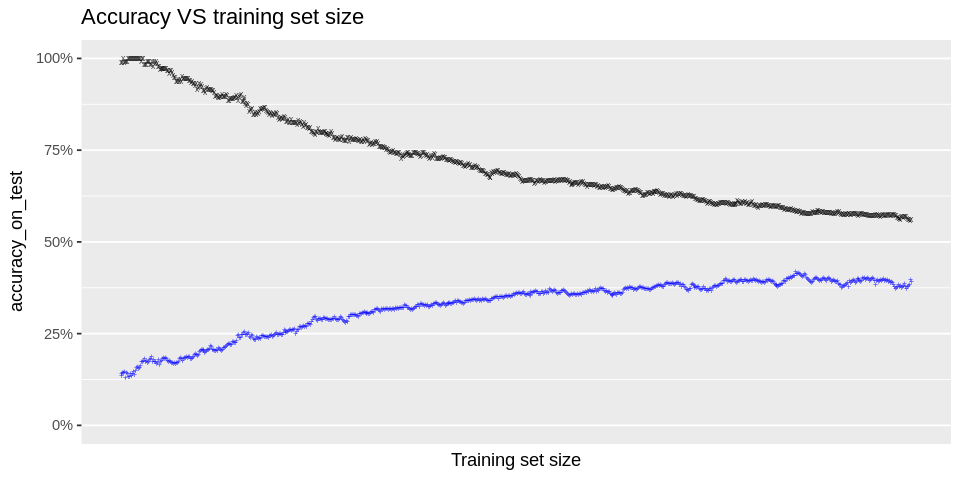

In [34]:
options(repr.plot.width=8, repr.plot.height=4)
options( warn = -1 );p;options( warn = 0 )

The model seems to stagnate as we increase the size of the dataset at arround 40% accuraccy